In [3]:
from scripts.sequence_labeling import f1_score, precision_score, recall_score, get_entities
from scripts.scheme import IOB2
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import pickle
import torch
from torch import nn
import torch.nn.functional as F
import nltk
from nltk.collocations import *
from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoModelForTokenClassification,
    AutoConfig,
)
from seqeval.metrics import f1_score, precision_score, recall_score
import csv

### 1. Read the train and test set

In [60]:
def capture_lines(df, column):
    """
    get sentences/entities in list of list
    """
    sep_list = list(df[df["word"] == "."].index)
    last_sep = 0
    list_sent = []
    for _, x in enumerate(sep_list):
        sentence = list(df[column][last_sep : x+1])
        list_sent.append(sentence)
        last_sep = x+1
    return list_sent

def entity_label_pair(ents, sents):
    """
    get entity label pair
    """
    entity_label = []
    for i, line in enumerate(ents):
        tmp_ent = []
        for j, e in enumerate(line):
            if e != 'O':
                tmp_ent.append(sents[i][j])
                if len(e) != 1:
                    lbl = e.split('-')[1]
                else:
                    # for BC5CDR
                    lbl = 'problem'
            elif tmp_ent:
                entity_label.append((' '.join(tmp_ent),lbl))
                tmp_ent = []
    return entity_label

def prepare_train_test(dir, train_test = 'train', mul_classes=True):
    """
    prepare the train df and test df used for EECR and CCR analysis
    """
    reads = pd.read_csv(dir, delimiter=" ", header = None, quoting=csv.QUOTE_NONE, encoding='utf-8')
    reads.columns = ["word", "label"]

    # get the BIO tags and classes in new columns
    if mul_classes:
        # for i2b2
        reads['BIO'] = reads['label'].str.split('-').str[0]
        reads['class'] = reads['label'].str.split('-').str[1].fillna('O')
    else:
        # for BC5CDR-disease
        reads['BIO'] = reads['label']
        reads['class'] = np.where(reads['label']=='O', 'O', 'problem')

    # prepare the dataframe to see the tag balance in preds and golds
    df = reads
    df['type'] = train_test.lower()

    # capture lines
    sents = capture_lines(df, "word")
    ents= capture_lines(df, "label")

    # get entity-label pair
    ent_label = entity_label_pair(ents, sents)

    # form into dataframes
    df_entity = pd.DataFrame(data=ent_label, columns=['entity', 'class'])
    cnt = df_entity.value_counts().reset_index(name='count')


    return sents, ents, cnt, reads

In [75]:
# train_dir = '../datasets/NER/i2b2-2010/processed/merged/train.txt'
train_dir = '../datasets/NER/BC5CDR-disease/train.txt'

test_dir = '../datasets/NER/i2b2-2010/processed/merged/test.txt'
# test_dir = '../datasets/NER/BC5CDR-disease/test.txt'

sents_t, ents_t, cnt_t, trains = prepare_train_test(train_dir, 'train', mul_classes=False)
sents_g, ents_g, cnt_g, golds = prepare_train_test(test_dir, 'train', mul_classes=True)

#### 2. Entity Coverage Ratio (ECR)
- Describe the degree to which entities in the test set have been seen in the training set with the same category.

In [76]:
df_common = pd.merge(cnt_t, cnt_g, on=['entity','class'], how='right', indicator='Exist')
df_overlap = df_common[df_common['Exist']=='both']
df_overlap

,entity,class,count_x,count_y,Exist
0,pain,problem,76.0,101,both
2,hypertension,problem,54.0,80,both
3,edema,problem,1.0,78,both
18,nausea,problem,24.0,64,both
19,shortness of breath,problem,1.0,63,both
...,...,...,...,...,...
13255,daytime sleepiness,problem,3.0,1,both
13295,bipolar disorder,problem,2.0,1,both
13494,cardiomyopathy,problem,8.0,1,both
13517,cancers,problem,3.0,1,both


In [77]:
unique_entities = df_overlap['entity'].unique()
df_metrics = pd.DataFrame(columns=['entity', 'count_t', 'count_g', 'ECR'])
for i, ent in enumerate(unique_entities):
    # because the same entity could belong to different classes
    df = df_overlap[df_overlap['entity']==ent]
    c_tr = df['count_x'].sum()
    c_te = df['count_y'].sum()
    tho = (df['count_x'].mul(df['count_y']).sum())/(c_tr*c_te)
    df_metrics.loc[i] = [ent, c_tr, c_te, tho]
df_metrics['freq_g'] = df_metrics['count_g']/df_metrics['count_g'].sum()
df_metrics

,entity,count_t,count_g,ECR,freq_g
0,pain,76.0,101,1.0,0.047822
1,hypertension,54.0,80,1.0,0.037879
2,edema,1.0,78,1.0,0.036932
3,nausea,24.0,64,1.0,0.030303
4,shortness of breath,1.0,63,1.0,0.029830
...,...,...,...,...,...
296,daytime sleepiness,3.0,1,1.0,0.000473
297,bipolar disorder,2.0,1,1.0,0.000473
298,cardiomyopathy,8.0,1,1.0,0.000473
299,cancers,3.0,1,1.0,0.000473


#### 3. Expectation of Entity Coverage Ratio (EECR)
- Measures the degree to which the test entities have been seen in the training set. A higher value is suggestive of a larger proportion of entities with high coverage ratio.

In [78]:
EECR = (df_metrics['ECR']*df_metrics['freq_g']).sum()
print(f"EECR = {EECR}")

EECR = 0.9999999999999999


#### 4. Contextual Coverage Ratio (CCR)
- measure the contextual similarity of entities belonging to the same category but from the training and the test sets, respectively.

In [10]:
def find_context(seq_sents, seq_ents, ws):
    """
    seq_sents: list of sentences
    seq_ents: list of entities
    return context_true: dictionry of context within problem/text/treatment categories
    """
    seqs = [item for _, sublist in enumerate(seq_sents) for item in sublist + ['O']] # record the label items

    suffix = None
    context_true = dict()
    context_true['problem'] = list()
    context_true['test'] = []
    context_true['treatment'] = []
    for type_name, start, end, _ in get_entities(seq_ents, suffix):
        if start-ws >= 0:
            left_context = seqs[start-ws:start]
            context_true[type_name].append(left_context)
        elif start != 0:
            left_context = seqs[0:start]
            context_true[type_name].append(left_context)
        if end+1+ws <= len(seqs):
            right_context = seqs[end+1:end+1+ws]
            context_true[type_name].append(right_context)
        elif end != len(seqs):
            right_context = seqs[end+1:len(seqs)]
            context_true[type_name].append(right_context)
        
    return context_true

def get_context_vectors(lst,tokenizer,model):
    joint_lst = []
    for contxt in lst:
        joint_lst.append(" ".join(contxt))
    encoded = tokenizer(joint_lst, padding=True)
    input_ids = torch.tensor(encoded.input_ids)
    out = model(input_ids)
    vectors = out.last_hidden_state.mean(dim=1)
    return vectors

In [11]:
# get word vectors
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)

def get_CCR(sents_t, ents_t, sents_g, ents_g, tokenizer, model):
    # find context
    context_tr_3 = find_context(sents_t, ents_t,ws=3)
    context_tr_2 = find_context(sents_t, ents_t,ws=2)
    context_te_3 = find_context(sents_g, ents_g,ws=3)
    context_te_2 = find_context(sents_g, ents_g,ws=2)
    # count the occurancies of context
    df_context_tr_3 = pd.DataFrame([" ".join(i) for i in context_tr_3['problem']], columns=['context']).value_counts().reset_index(name='count')[:20]
    df_context_tr_2 = pd.DataFrame([" ".join(i) for i in context_tr_2['problem']], columns=['context']).value_counts().reset_index(name='count')[:30]
    df_context_te_3 = pd.DataFrame([" ".join(i) for i in context_te_3['problem']], columns=['context']).value_counts().reset_index(name='count')[:20]
    df_context_te_2 = pd.DataFrame([" ".join(i) for i in context_te_2['problem']], columns=['context']).value_counts().reset_index(name='count')[:20]

    df_context_tr = pd.concat([df_context_tr_3, df_context_tr_2],ignore_index=True)
    df_context_te = pd.concat([df_context_te_3, df_context_te_2],ignore_index=True)

    # find the frequency
    df_context_tr['p_f'] = df_context_tr['count']/df_context_tr['count'].sum()
    df_context_te['p_f'] = df_context_te['count']/df_context_te['count'].sum()

    t = list(df_context_tr['context'])
    g = list(df_context_te['context'])
    score_t = list(df_context_tr['p_f'])[0:50]
    score_g = list(df_context_te['p_f'])[0:50]

    vector_tr = get_context_vectors(t,tokenizer,model)
    vector_te = get_context_vectors(g,tokenizer,model)

    # calculate CCR
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    out = 0
    for i, input1 in enumerate(vector_tr):
        for j, input2 in enumerate(vector_te):
            sim = cos(input1.unsqueeze(dim=0), input2.unsqueeze(dim=0))
            out += score_t[i]*score_g[j]*sim
    
    return out

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
get_CCR(sents_t, ents_t, sents_g, ents_g, tokenizer, model)

tensor([0.8798], grad_fn=<AddBackward0>)

In [19]:
import seaborn as sns
#load the dataset
df = sns.load_dataset('iris')
#calculate correlation
corr_matrix = df.corr('pearson') #kind of correlation->  ‘pearson’, ‘kendall’, ‘spearman’
#plot correlation
corr_matrix.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.117570,0.871754,0.817941
sepal_width,-0.117570,1.000000,-0.428440,-0.366126
petal_length,0.871754,-0.428440,1.000000,0.962865
petal_width,0.817941,-0.366126,0.962865,1.000000


In [79]:
dff = pd.DataFrame()
# dff['AC1'] = pd.Series([0.8913, 0.8798])
# dff['AC2'] = pd.Series([0.8847, 0.9068])
# dff['BC1'] = pd.Series([0.8303, 0.6283])
# dff['BC2'] = pd.Series([0.6779, 0.9007])
# dff['AR1'] = pd.Series([0.8913, 0.8847])
# dff['AR2'] = pd.Series([0.8798, 0.9068])
# dff['BR1'] = pd.Series([0.8303, 0.6779])
# dff['BR2'] = pd.Series([0.6283, 0.9007])
dff['F1 score'] = pd.Series([0.8303, 0.6779, 0.6283, 0.9007])
dff['CCR'] = pd.Series([0.8913, 0.8847, 0.8798, 0.9068])
dff['EECR'] = pd.Series([1.0, 0.9999, 0.9999, 0.9925])
dff

,F1 score,CCR,EECR
0,0.8303,0.8913,1.0000
1,0.6779,0.8847,0.9999
2,0.6283,0.8798,0.9999
3,0.9007,0.9068,0.9925


In [87]:
#calculate correlation
corr_matrix = dff.corr('pearson') #kind of correlation->  ‘pearson’, ‘kendall’, ‘spearman’
#plot correlation
corr_matrix.style.background_gradient(cmap="Blues")
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

,F1 score,CCR,EECR
F1 score,1.000000,0.941666,-0.730580
CCR,0.941666,1.000000,-0.911433
EECR,-0.730580,-0.911433,1.000000


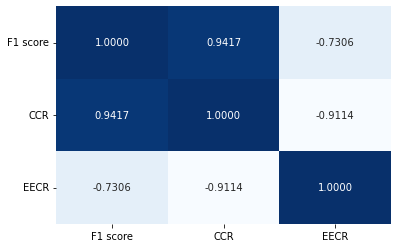

In [92]:
fig, ax = plt.subplots()
sns.heatmap(dff.corr(method='pearson'), annot=True, fmt='.4f', 
            cmap=plt.get_cmap('Blues'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('./result.png', bbox_inches='tight', pad_inches=0.0)

In [95]:
fig.show

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

In [22]:
## decrease in performance line plot
df_drop = pd.DataFrame()
df_drop['status'] = pd.Series(['original', 'cross-dataset', 'original', 'cross-dataset'])
df_drop['f1-score'] = pd.Series([0.915, 0.724, 0.951, 0.752])
df_drop['model'] = pd.Series(['Stanza-Bio','Stanza-Bio','Stanza-Clinical','Stanza-Clinical'])
df_drop

,status,f1-score,model
0,original,0.915,Stanza-Bio
1,cross-dataset,0.724,Stanza-Bio
2,original,0.951,Stanza-Clinical
3,cross-dataset,0.752,Stanza-Clinical


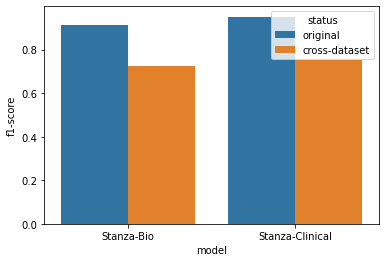

In [23]:
p = sns.barplot(data=df_drop,x="model",y="f1-score",hue="status")

# p.set_xlabel("status", fontsize = 10)
# p.set_ylabel("f1 performance", fontsize = 10)
# p.set_xticklabels(["previous", "later"])